In [123]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from datasist.structdata import detect_outliers



## other
#from imblearn.over_sampling import SMOTE

## sklearn -- preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_features.transformers import DataFrameSelector
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

## sklearn -- models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor

## skelarn -- metrics
from sklearn.metrics import f1_score, accuracy_score, r2_score

## ensemble models
from sklearn.ensemble import VotingRegressor,  AdaBoostRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor

### `Data URL`
- https://www.kaggle.com/code/touba7/insurance-prediction-with-five-regressor-models/data

### `Read Dataset`

In [78]:
df = pd.read_csv("insurance.csv", na_values=['Unknown', '', 'na', 'nan', 'NA', 'NAN' ])
df.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [79]:
df.shape

(1338, 7)

In [80]:
# trim and replace space inside columns names with _
df.columns = df.columns.str.lower().str.strip().str.strip().str.replace(' ', '_')
df.rename(columns={'sex':'gender'}, inplace=True)
df.head(3)

,age,gender,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


### `Check the datatypes of the columns`

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   gender    1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [82]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [83]:
df.describe(include=['O'])

,gender,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


### `Check number of NA cells in each column`

In [84]:
# print the percentage of null cells in each column ordered desc 
df.isna().sum().sort_values(ascending=False) / df.shape[0]

age         0.0
gender      0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

### `Feature Engineering`

#### `Create age_group contains the values (Infants, Children, Adolescents, Adults, Older)`

In [85]:
bins= [0,20,40,60,80]
labels = ['less_than_20','less_than_40','less_than_60','less_than_80']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False).astype(object)
df.loc[:,['age', 'age_group']]


,age,age_group
0,19,less_than_20
1,18,less_than_20
2,28,less_than_40
3,33,less_than_40
4,32,less_than_40
...,...,...
1333,50,less_than_60
1334,18,less_than_20
1335,18,less_than_20
1336,21,less_than_40


### `Visualization`

 
boxplot of charges


##### `Draw histogram of Body mass index "bmi"  given gender`

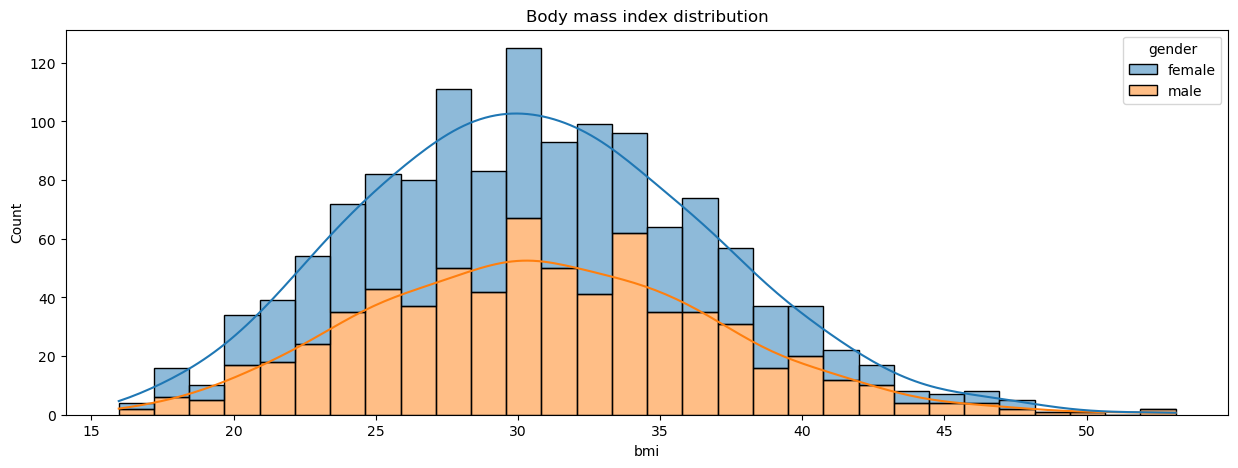

In [86]:
plt.figure(figsize=(15,5))
sns.histplot(data=df, x='bmi', hue='gender', bins=30, multiple='stack', kde=True)
plt.title('Body mass index distribution')
plt.show()

##### `Draw number of smokers/non-smokers divided by age_group`

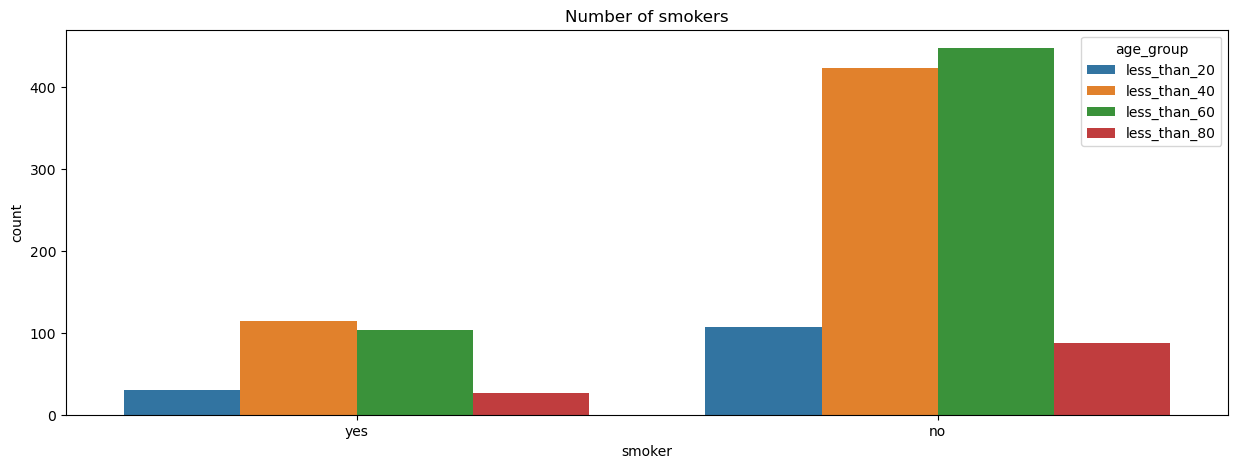

In [87]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, x='smoker', hue='age_group')
plt.title('Number of smokers')
plt.show()

##### `Draw number of clients in each region divided by age_group`

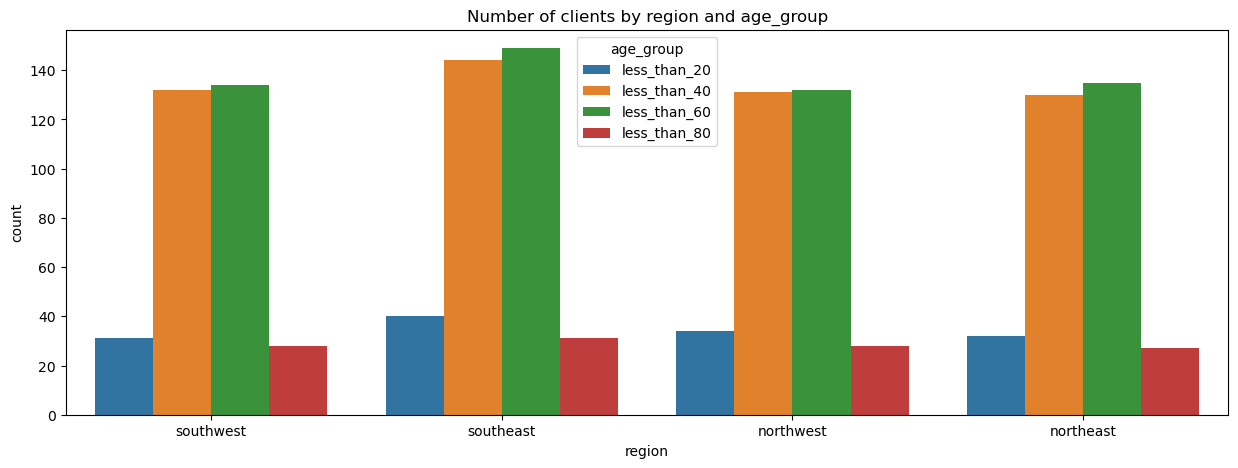

In [88]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, x='region', hue='age_group')
plt.title('Number of clients by region and age_group')
plt.show()

### `boxplot of Body Mass Index bmi based on gender and age-group`

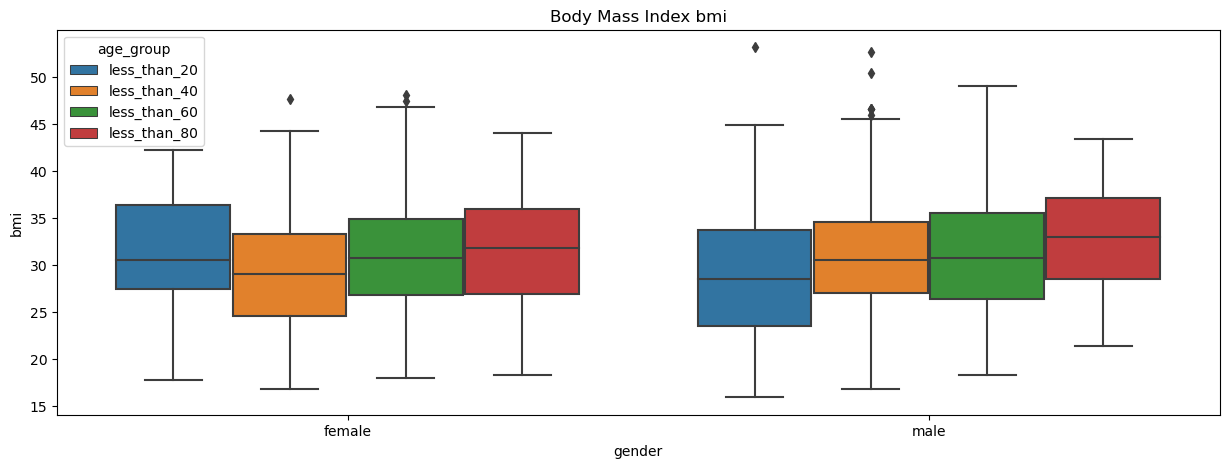

In [89]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, y='bmi', x='gender', hue='age_group')
plt.title('Body Mass Index bmi')
plt.show()

### `Scatterplot of charges based age, smoker/non-smoker and bmi`

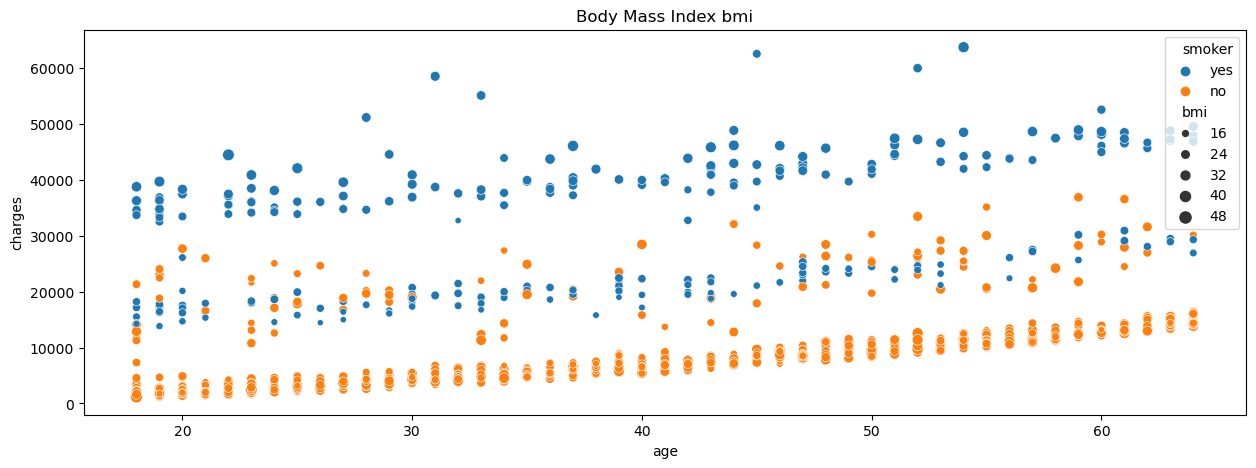

In [90]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=df, y='charges', x='age', hue='smoker', size='bmi' )
plt.title('Body Mass Index bmi')
plt.show()

Conclusion:
- Charges increases for smokers

### `Draw histogram for numerical fields`

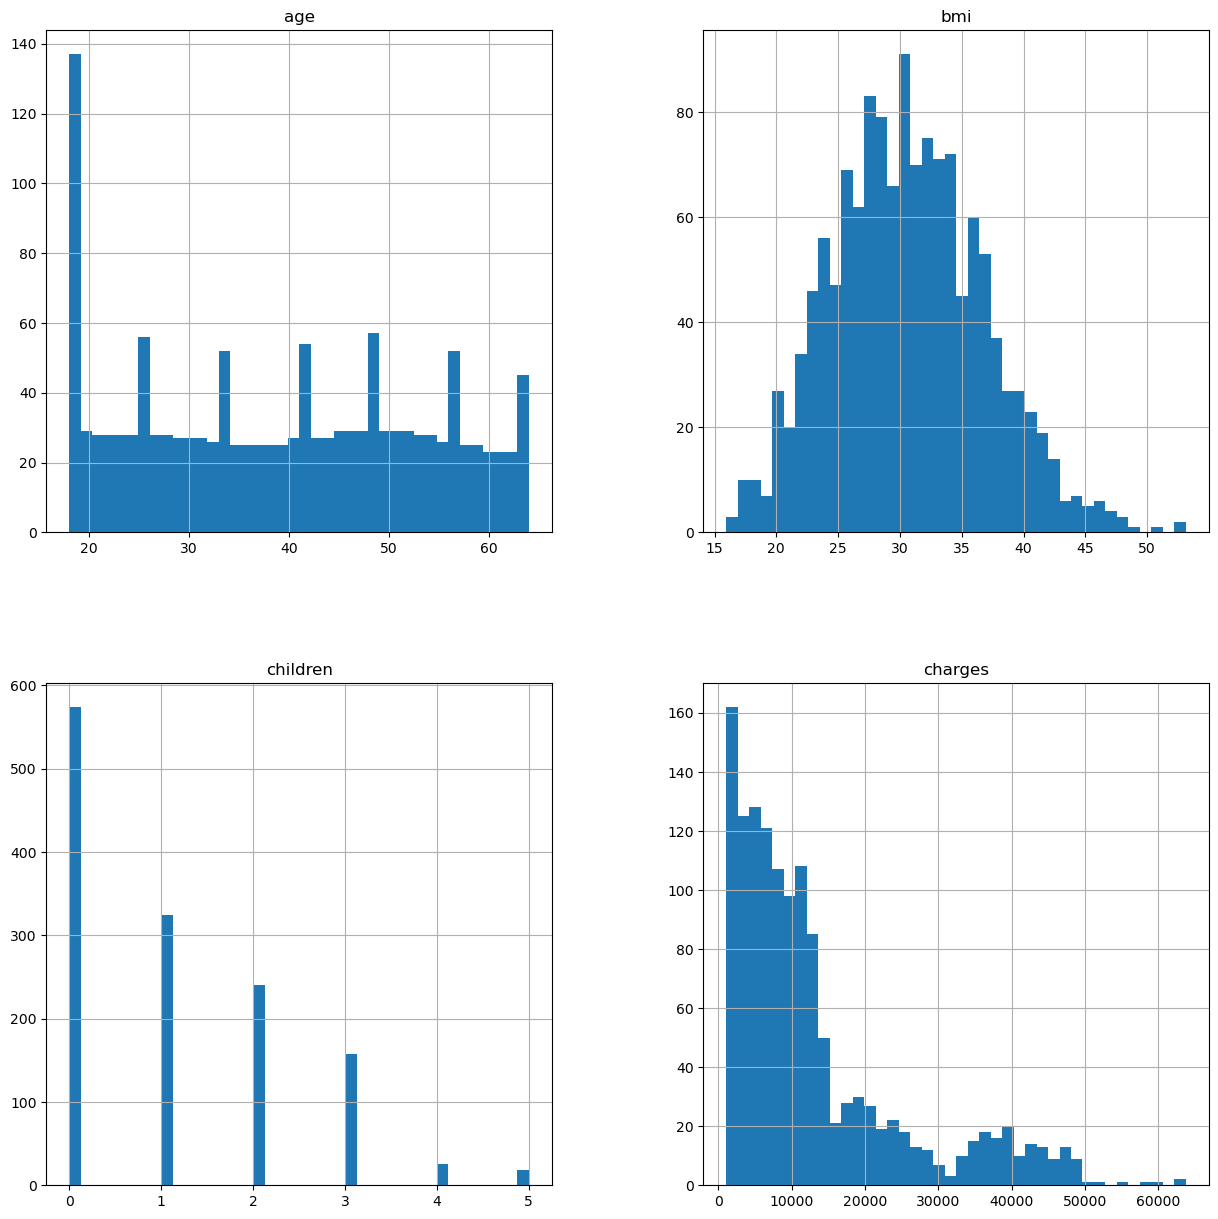

In [91]:
df.hist(bins=40, figsize=(15,15))
plt.show()

### `Split Data into train and validation datasets`

In [92]:
## Features and target
X = df.drop(columns=['charges'], axis=1)
y = df['charges']

## to full train and test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=45)

print('X_train shape', X_train.shape)
print('X_valid shape', X_valid.shape)
print('y_train shape', y_train.shape)
print('y_valid shape', y_valid.shape)

X_train shape (1070, 7)
X_valid shape (268, 7)
y_train shape (1070,)
y_valid shape (268,)


#### `Data Preprocessing`

In [93]:
## Slice cols
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
categ_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(categ_cols) 
print(num_cols)

['gender', 'smoker', 'region', 'age_group']
['age', 'bmi', 'children']


In [94]:
## Pipeline 

## Numerical --> Impute using median, Standardization
## Cateforical --> Impute using mode, Ordinal


In [95]:
## Numerical
num_pipline = Pipeline(steps=[
                ('selector', DataFrameSelector(num_cols)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ])

## Categorical
categ_pipline = Pipeline(steps=[
                 ('selector', DataFrameSelector(categ_cols)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder())
])


## Combine all
all_pipeline = FeatureUnion(transformer_list=[
                        ('num', num_pipline),
                        ('categ', categ_pipline)
                    ])

## apply
X_train_final  = all_pipeline.fit_transform(X_train)
X_valid_final = all_pipeline.transform(X_valid)



In [96]:
## Check shapes

print('X_train_final.shape \t', X_train_final.shape)
print('y_train_encoded.shape \t', y_train.shape)
print('**'*20)
print('X_valid_final.shape \t', X_valid_final.shape)
print('y_valid_encoded.shape \t', y_valid.shape)  ## fine

X_train_final.shape 	 (1070, 7)
y_train_encoded.shape 	 (1070,)
****************************************
X_valid_final.shape 	 (268, 7)
y_valid_encoded.shape 	 (268,)


#### `Building Models`

`Let's consider evaluation metric f1_score `

#### 1. Linear Regression

In [97]:
## Model Training
lin_reg = LinearRegression()
lin_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_lin = lin_reg.predict(X_train_final)
y_pred_valid_lin = lin_reg.predict(X_valid_final)

## Evaluate
score_train_lin = r2_score(y_train, y_pred_train_lin)
score_valid_lin = r2_score(y_valid, y_pred_valid_lin)

print(f'R2 Score for Training Dataset using LinearRegression {score_train_lin * 100 :.3f}')
print(f'R2 Score for Valid Dataset using LinearRegression {score_valid_lin * 100 :.3f}')

R2 Score for Training Dataset using LinearRegression 76.037
R2 Score for Valid Dataset using LinearRegression 70.352


#### 2. Polynomail Features

In [98]:
# Initialize Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Polynomial fitting and transforming
X_train_final2 = poly.fit_transform(X_train_final)
X_valid_final2 = poly.transform(X_valid_final)


## Model Training
lin_poly_reg = LinearRegression()
lin_poly_reg.fit(X_train_final2, y_train)

## Predict and evaluate 
y_pred_train_lin_poly = lin_poly_reg.predict(X_train_final2)
y_pred_valid_lin_poly = lin_poly_reg.predict(X_valid_final2)

## Evaluate
score_train_lin_poly = r2_score(y_train, y_pred_train_lin_poly)
score_valid_lin_poly = r2_score(y_valid, y_pred_valid_lin_poly)

print(f'R2 Score for Training Dataset using LinearRegression with PolynomialFeatures {score_train_lin_poly * 100 :.3f}')
print(f'R2 Score for Valid Dataset using LinearRegression with PolynomialFeatures {score_valid_lin_poly * 100 :.3f}')

R2 Score for Training Dataset using LinearRegression with PolynomialFeatures 85.303
R2 Score for Valid Dataset using LinearRegression with PolynomialFeatures 81.565


#### 3. Random Forest

In [99]:
## Model Training
forst_reg = RandomForestRegressor(n_estimators=150, max_depth=5, random_state=45)
forst_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_forest = forst_reg.predict(X_train_final)
y_pred_valid_forest = forst_reg.predict(X_valid_final)

## Evaluate
score_train_forest = r2_score(y_train, y_pred_train_forest)
score_valid_forest = r2_score(y_valid, y_pred_valid_forest)

print(f'R2 Score for Training Dataset using RF {score_train_forest * 100 :.3f}')
print(f'R2 Score for Valid Dataset using RF {score_valid_forest * 100 :.3f}')

R2 Score for Training Dataset using RF 89.703
R2 Score for Valid Dataset using RF 83.523


#### 4. KNN

In [100]:
## Model Training
knn_reg = KNeighborsRegressor(n_neighbors=40, p=1, n_jobs=-1)
knn_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_knn = knn_reg.predict(X_train_final)
y_pred_valid_knn = knn_reg.predict(X_valid_final)

## Evaluate
score_train_knn = r2_score(y_train, y_pred_train_knn)
score_valid_knn = r2_score(y_valid, y_pred_valid_knn)

print(f'R2 Score for Training Dataset using knn {score_train_knn * 100 :.3f}')
print(f'R2 Score for Valid Dataset using knn {score_valid_knn * 100 :.3f}')

R2 Score for Training Dataset using knn 56.937
R2 Score for Valid Dataset using knn 53.676


#### 5. SGD with Early Stopping

In [101]:
## Model Training
SGD_reg = SGDRegressor(penalty=None, learning_rate='constant', eta0=0.001, early_stopping=True, 
                       n_iter_no_change=100, validation_fraction=0.1, max_iter=5000)
SGD_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_SGD = SGD_reg.predict(X_train_final)
y_pred_valid_SGD = SGD_reg.predict(X_valid_final)

## Evaluate
score_train_SGD = r2_score(y_train, y_pred_train_SGD)
score_valid_SGD = r2_score(y_valid, y_pred_valid_SGD)

print(f'R2 Score for Training Dataset using SGDRegressor {score_train_SGD * 100 :.3f}')
print(f'R2 Score for Valid Dataset using SGDRegressor {score_valid_SGD * 100 :.3f}')

R2 Score for Training Dataset using SGDRegressor 76.012
R2 Score for Valid Dataset using SGDRegressor 70.417


#### 6. Ensemble Learning: Voting

In [105]:
## Voting for (LinearRegression, RandomForest, KNeighbors, SGDRegressor) 
voting_reg = VotingRegressor(estimators=[
                                    ('lin_reg', lin_reg),
                                    ('forst_reg', forst_reg),
                                    ('knn_reg ', knn_reg ),
                                    ('SGD_reg', SGD_reg)
                                        ])


voting_reg.fit(X_train_final, y_train) 

## Predict and evaluate 
y_pred_train_voting = voting_reg.predict(X_train_final)
y_pred_valid_voting = voting_reg.predict(X_valid_final)

## Evaluate
score_train_voting = r2_score(y_train, y_pred_train_voting)
score_valid_voting = r2_score(y_valid, y_pred_valid_voting)

print(f'R2 Score for Training Dataset using voting {score_train_voting * 100 :.3f}')
print(f'R2 Score for Valid Dataset using voting {score_valid_voting * 100 :.3f}')

R2 Score for Training Dataset using voting 81.297
R2 Score for Valid Dataset using voting 77.092


#### 7. Ensemble Learning: Bagging -> RandomForest

In [116]:
## Model Training
forst_reg = RandomForestRegressor(n_estimators=150, max_depth=5, max_features=0.8, random_state=45,
                                    max_samples=0.8, bootstrap=True, oob_score=True)
forst_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_forest = forst_reg.predict(X_train_final)
y_pred_valid_forest = forst_reg.predict(X_valid_final)

## Evaluate
score_train_forest = r2_score(y_train, y_pred_train_forest)
score_valid_forest = r2_score(y_valid, y_pred_valid_forest)

print(f'R2 Score for Training Dataset using Bagging - RF {score_train_forest * 100 :.3f}')
print(f'R2 Score for Valid Dataset using Bagging - RF {score_valid_forest * 100 :.3f}')

R2 Score for Training Dataset using Bagging - RF 89.336
R2 Score for Valid Dataset using Bagging - RF 83.555


#### 8. Ensemble Learning: Boosting -> AdaBoost

In [117]:
## Model Training
adaboost_reg = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=5, 
                                                                        max_features=0.8, random_state=48),
                                    n_estimators=150, learning_rate=1)
adaboost_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_adaboost = adaboost_reg.predict(X_train_final)
y_pred_valid_adaboost = adaboost_reg.predict(X_valid_final)

## Evaluate
score_train_adaboost = r2_score(y_train, y_pred_train_adaboost)
score_valid_adaboost = r2_score(y_valid, y_pred_valid_adaboost)

print(f'R2 Score for Training Dataset using AdaBoostRegressor {score_train_adaboost * 100 :.3f}')
print(f'R2 Score for Valid Dataset using AdaBoostRegressor {score_valid_adaboost * 100 :.3f}')

R2 Score for Training Dataset using AdaBoostRegressor 69.806
R2 Score for Valid Dataset using AdaBoostRegressor 58.796


#### 9. Ensemble Learning: Boosting -> GradientBoosting

In [119]:
## Model Training
gradient_reg = GradientBoostingRegressor(n_estimators=150, max_depth=5, learning_rate=0.1)
gradient_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_gradient = gradient_reg.predict(X_train_final)
y_pred_valid_gradient = gradient_reg.predict(X_valid_final)

## Evaluate
score_train_gradient = r2_score(y_train, y_pred_train_gradient)
score_valid_gradient = r2_score(y_valid, y_pred_valid_gradient)

print(f'R2 Score for Training Dataset using GradientBoosting {score_train_gradient * 100 :.3f}')
print(f'R2 Score for Valid Dataset using GradientBoosting {score_valid_gradient * 100 :.3f}')

R2 Score for Training Dataset using GradientBoosting 97.741
R2 Score for Valid Dataset using GradientBoosting 80.049


#### 10. XGBoost

In [126]:
## Model Training
XGB_reg = XGBRegressor(n_estimators=120, max_depth=5, 
                        colsample_bytree=0.8, subsample=0.9, reg_lambda=100, learning_rate=0.2)
XGB_reg.fit(X_train_final, y_train)

## Predict and evaluate 
y_pred_train_XGB = XGB_reg.predict(X_train_final)
y_pred_valid_XGB = XGB_reg.predict(X_valid_final)

## Evaluate
score_train_XGB = r2_score(y_train, y_pred_train_XGB)
score_valid_XGB = r2_score(y_valid, y_pred_valid_XGB)

print(f'R2 Score for Training Dataset using XGBRegressor {score_train_XGB * 100 :.3f}')
print(f'R2 Score for Valid Dataset using XGBRegressor {score_valid_XGB * 100 :.3f}')

R2 Score for Training Dataset using XGBRegressor 91.272
R2 Score for Valid Dataset using XGBRegressor 83.289
